# STEP 1: Model to identify pupil and then get areas

In [1]:
import os
import json
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class PupilDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img_ann = img_name + '.json'
        ann_path = os.path.join(self.annotations_dir, img_ann)

        image = np.array(Image.open(img_path).convert('RGB'))
        with open(ann_path) as f:
            annotations = json.load(f)

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        for obj in annotations['objects']:
            if obj['classTitle'] == 'Pupil':
                points = np.array(obj['points']['exterior'])
                cv2.fillPoly(mask, [points], color=1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [5]:
# The relevant transformations to the data for better accuracy (like intensity normalisation)

transform = A.Compose([
    A.Resize(256, 256),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [6]:
# initialising a dataset
dataset = PupilDataset(
    images_dir='/content/drive/MyDrive/Academic Endeavours/AI4Good/pupil_images',
    annotations_dir='/content/drive/MyDrive/Academic Endeavours/AI4Good/pupil_annotations',
    transform=transform
)

test_dataset = PupilDataset(
    images_dir='/content/drive/MyDrive/Academic Endeavours/AI4Good/test_images',
    annotations_dir='/content/drive/MyDrive/Academic Endeavours/AI4Good/test_annotations',
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=2)

# sample_image, sample_mask = next(iter(dataloader))
# print(sample_image.shape)
# print(sample_mask.shape)

In [32]:
# model settings (can change)

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# model evaluation

import tqdm

def accuracy(outputs, labels):
  predictions = torch.round(torch.sigmoid(outputs)) # Round the sigmoid output to get binary predictions
  correct = torch.sum(labels == predictions).item()
  return correct / labels.numel() # Use numel() to count all elements in the tensor

def evaluate(loader, model, loss_function, device):
  acc = 0
  loss = 0
  n_samples = 0

  model = model.to(device)
  model.eval() # Some neural networks can behave differently between training and evaluation.
               # By using `eval` we make sure the model is in evaluation mode.

  # We iterate over all the testset, loading one batch of images at a time and computing the accuracy for the batch.
  for images, labels in tqdm.tqdm(loader):
    with torch.no_grad(): # When evaluating the model we don't need to compute the gradients,
                          # so we can disable it using `no_grad()`.
      # Move the tensor to appropriate device
      images = images.to(device)
      labels = labels.to(device)

      labels = labels.float()

      # Compute the outputs of the model
      outputs = model(images.float())['out']

      outputs = outputs.squeeze(1)

      # Compute the loss
      loss += loss_function(outputs, labels).item()*len(labels)

      # Compute the accuracy
      acc += accuracy(outputs, labels)*len(labels)
      n_samples += len(labels)

  return loss / n_samples, acc / n_samples

In [33]:
# Training Loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(num_epochs):
    train_acc = 0
    model.train()
    running_loss = 0.0
    for images, masks in tqdm.tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        masks = masks.unsqueeze(1).float()  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(images.float())['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_acc += accuracy(outputs, masks)*len(masks)
    torch.save(model.state_dict(), 'pupil_segmentation_model.pth')


    test_loss, test_acc = evaluate(testloader, model, nn.BCEWithLogitsLoss(), device)

    train_accuracies.append(train_acc / len(dataloader))
    train_losses.append(running_loss/len(dataloader))
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train loss: {running_loss:.2e}, Train accuracy: {train_acc:.2%}, Test accuracy: {test_acc:.2%}')



100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


Epoch: 1/10, Train loss: 5.39e+00, Train accuracy: 13457.37%, Test accuracy: 86.46%


100%|██████████| 19/19 [00:06<00:00,  2.87it/s]


Epoch: 2/10, Train loss: 1.87e+00, Train accuracy: 14814.39%, Test accuracy: 98.47%


100%|██████████| 19/19 [00:06<00:00,  2.84it/s]


Epoch: 3/10, Train loss: 1.09e+00, Train accuracy: 14841.69%, Test accuracy: 98.16%


100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Epoch: 4/10, Train loss: 7.18e-01, Train accuracy: 14854.51%, Test accuracy: 97.84%


100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


Epoch: 5/10, Train loss: 5.40e-01, Train accuracy: 14851.97%, Test accuracy: 98.12%


 47%|████▋     | 7/15 [00:06<00:07,  1.05it/s]


KeyboardInterrupt: 

In [48]:
from google.colab import files

files.download('pupil_segmentation_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
train_accuracies = [x / 100 for x in train_accuracies]


In [56]:
print(train_accuracies)
print(train_losses)
print(test_losses)
print(test_accuracies)

[0.897158203125, 0.9876258341471355, 0.9894460042317709, 0.9903005981445313, 0.9901310221354167]
[0.3590983092784882, 0.12482786824305853, 0.0728043757379055, 0.04783364658554395, 0.03597184841831525]
[0.6113705019265907, 0.10270726417309671, 0.08810957615876067, 0.07910162502724821, 0.06534248895078733]
[0.8645503428759496, 0.9847176904836412, 0.981567720023308, 0.9784209530656509, 0.9812074102749482]


Text(0.5, 1.0, 'Accuracy')

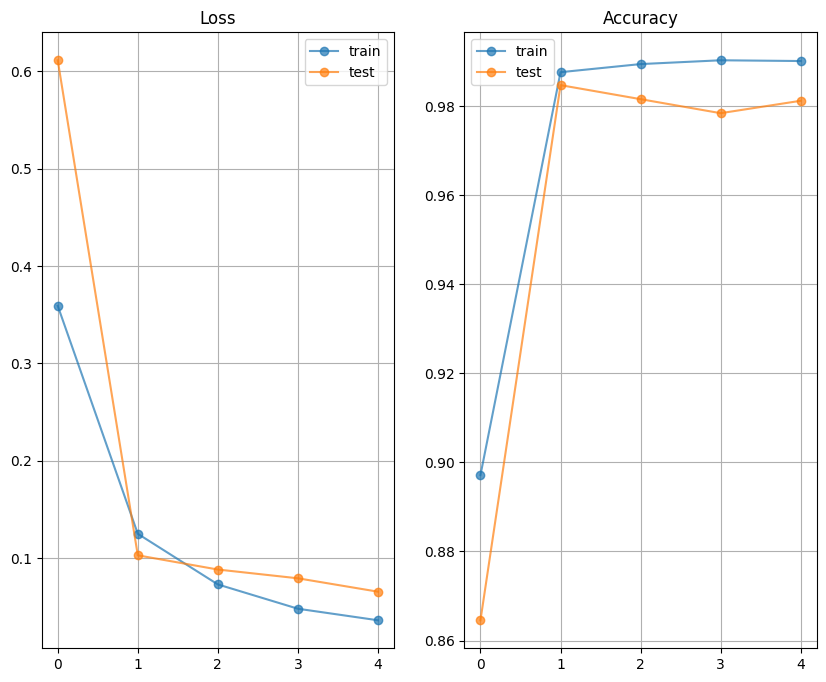

In [57]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train', marker='o', alpha=0.7)
plt.plot(test_losses, label='test', marker='o', alpha=0.7)
plt.grid(True)
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='train', marker = 'o', alpha = 0.7)
plt.plot(test_accuracies, label='test', marker='o', alpha=0.7)
plt.grid(True)
plt.legend()
plt.title('Accuracy')

In [35]:
# code to run some extra epochs to lower loss further

num_epochs = 2
for epoch in range(num_epochs):
    model.load_state_dict(torch.load('pupil_segmentation_model.pth'))
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.unsqueeze(1).float()  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(images.float())['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    torch.save(model.state_dict(), 'pupil_segmentation_model.pth')

KeyboardInterrupt: 

In [ ]:
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}')

Epoch [2/2], Loss: 0.004491415216277043


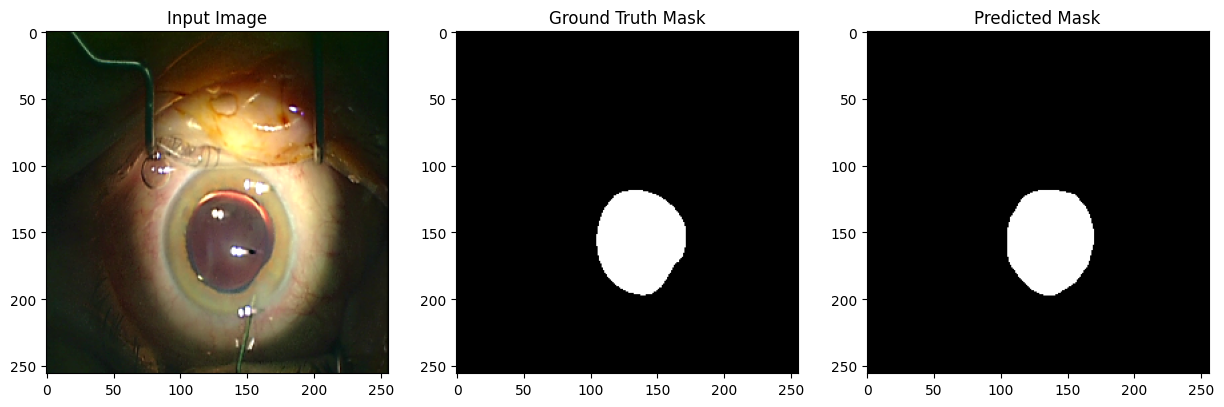

In [36]:
sample_image, sample_mask = next(iter(dataloader))
sample_image = sample_image.to(device)
with torch.no_grad():
    output = model(sample_image.float())['out']
    preds = torch.sigmoid(output).cpu().numpy()
    preds = preds > 0.5

# Visualize Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_image[0].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Input Image')
axes[1].imshow(sample_mask[0].cpu().numpy(), cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[2].imshow(preds[0][0], cmap='gray')
axes[2].set_title('Predicted Mask')
plt.show()

In [37]:
# code to get pupil area
def get_pupil_area(output, batch_size):
  with torch.no_grad():
    preds = torch.sigmoid(output).cpu().numpy()
    preds = preds > 0.5

  pupil_areas = {}

  for i in range(batch_size):
    count = 0
    for array in preds[i][0]:
      count += array.sum()
    pupil_areas[i] = count

  return pupil_areas


# STEP 2: Get frames from pupil videos

In [38]:
# installing frame library

!pip install decord

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 46.8 MB/s eta 0:00:00


In [39]:
# making video files more accessible

import glob

videos = []
for name in glob.glob('/content/drive/MyDrive/Academic Endeavours/AI4Good/Enigma/files/*'):
  videos.append(name)




In [40]:
from decord import VideoReader
import torch
import torch.nn.functional as F
import decord

device = torch.device('cuda')

decord.bridge.set_bridge('torch')
vr = VideoReader('/content/drive/MyDrive/Academic Endeavours/AI4Good/Enigma/files/case_2000.mp4')
frames = vr.get_batch(range(0, len(vr) - 1, 100))

frames = F.interpolate(frames.permute(0, 3, 1, 2), size=(256, 256), mode='bilinear', align_corners=False)
frames = frames.to(device)





In [41]:
with torch.no_grad():
    output = model(frames.float())['out']

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [42]:
print(output.shape)

with torch.no_grad():
   preds = torch.sigmoid(output).cpu().numpy()
   preds = preds > 0.5

torch.Size([428, 1, 256, 256])


Text(0.5, 1.0, 'Predicted Mask')

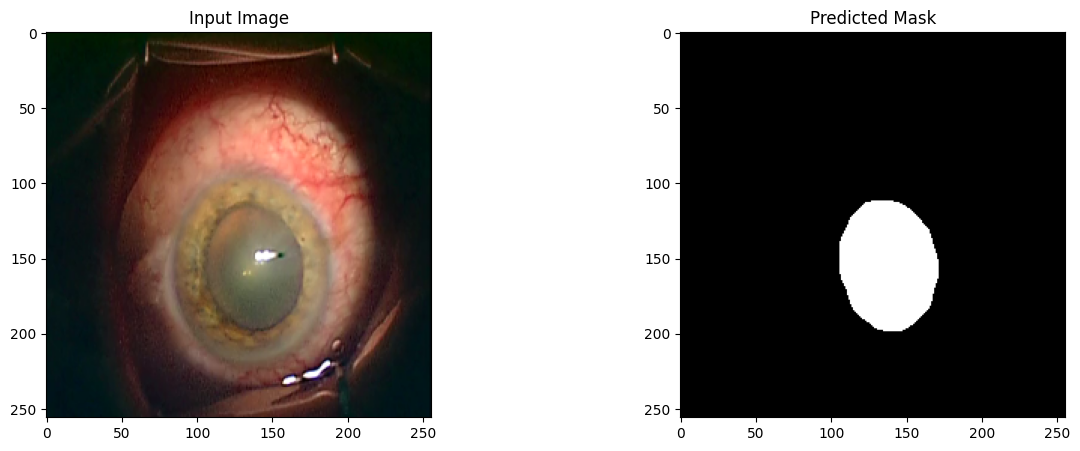

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(frames[0].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Input Image')
axes[1].imshow(preds[0][0], cmap='gray')
axes[1].set_title('Predicted Mask')

In [44]:
print(get_pupil_area(output, 428))

{0: 4512, 1: 4428, 2: 4527, 3: 4452, 4: 4473, 5: 4350, 6: 5971, 7: 4519, 8: 4597, 9: 4659, 10: 4866, 11: 4434, 12: 4360, 13: 4418, 14: 4382, 15: 4690, 16: 4682, 17: 3418, 18: 4458, 19: 4350, 20: 4415, 21: 4137, 22: 4590, 23: 4685, 24: 4757, 25: 3028, 26: 4696, 27: 4798, 28: 4679, 29: 4879, 30: 5155, 31: 5133, 32: 5137, 33: 5013, 34: 4686, 35: 4934, 36: 4045, 37: 4665, 38: 4122, 39: 4819, 40: 4987, 41: 4636, 42: 5026, 43: 4187, 44: 5021, 45: 4933, 46: 4448, 47: 4574, 48: 4910, 49: 4774, 50: 4673, 51: 4550, 52: 4803, 53: 4345, 54: 4353, 55: 4311, 56: 4368, 57: 4447, 58: 4408, 59: 4352, 60: 4379, 61: 4319, 62: 4334, 63: 4569, 64: 4620, 65: 4736, 66: 5039, 67: 4745, 68: 4848, 69: 5771, 70: 4712, 71: 4632, 72: 4619, 73: 4760, 74: 4532, 75: 4588, 76: 4508, 77: 4720, 78: 4671, 79: 4679, 80: 3887, 81: 4943, 82: 5356, 83: 5414, 84: 5054, 85: 4717, 86: 4007, 87: 4152, 88: 3917, 89: 4024, 90: 3999, 91: 3990, 92: 2461, 93: 2645, 94: 4596, 95: 4416, 96: 4495, 97: 4368, 98: 4495, 99: 5100, 100: 4295

In [1]:
pupil_area_dict = {0: 4512, 1: 4428, 2: 4527, 3: 4452, 4: 4473, 5: 4350, 6: 5971, 7: 4519, 8: 4597, 9: 4659, 10: 4866, 11: 4434, 12: 4360, 13: 4418, 14: 4382, 15: 4690, 16: 4682, 17: 3418, 18: 4458, 19: 4350, 20: 4415, 21: 4137, 22: 4590, 23: 4685, 24: 4757, 25: 3028, 26: 4696, 27: 4798, 28: 4679, 29: 4879, 30: 5155, 31: 5133, 32: 5137, 33: 5013, 34: 4686, 35: 4934, 36: 4045, 37: 4665, 38: 4122, 39: 4819, 40: 4987, 41: 4636, 42: 5026, 43: 4187, 44: 5021, 45: 4933, 46: 4448, 47: 4574, 48: 4910, 49: 4774, 50: 4673, 51: 4550, 52: 4803, 53: 4345, 54: 4353, 55: 4311, 56: 4368, 57: 4447, 58: 4408, 59: 4352, 60: 4379, 61: 4319, 62: 4334, 63: 4569, 64: 4620, 65: 4736, 66: 5039, 67: 4745, 68: 4848, 69: 5771, 70: 4712, 71: 4632, 72: 4619, 73: 4760, 74: 4532, 75: 4588, 76: 4508, 77: 4720, 78: 4671, 79: 4679, 80: 3887, 81: 4943, 82: 5356, 83: 5414, 84: 5054, 85: 4717, 86: 4007, 87: 4152, 88: 3917, 89: 4024, 90: 3999, 91: 3990, 92: 2461, 93: 2645, 94: 4596, 95: 4416, 96: 4495, 97: 4368, 98: 4495, 99: 5100, 100: 4295, 101: 4198, 102: 4780, 103: 4544, 104: 5090, 105: 5144, 106: 5090, 107: 4895, 108: 4821, 109: 4870, 110: 4953, 111: 4931, 112: 5140, 113: 4996, 114: 5145, 115: 5173, 116: 4994, 117: 5191, 118: 5156, 119: 4863, 120: 5216, 121: 5255, 122: 5162, 123: 5295, 124: 5595, 125: 5061, 126: 5256, 127: 5569, 128: 5416, 129: 5298, 130: 5131, 131: 5383, 132: 5248, 133: 5032, 134: 4825, 135: 4789, 136: 5354, 137: 5431, 138: 5276, 139: 4736, 140: 4784, 141: 4971, 142: 4931, 143: 5030, 144: 4515, 145: 4588, 146: 5460, 147: 5066, 148: 4900, 149: 4760, 150: 4797, 151: 4829, 152: 4729, 153: 4719, 154: 5074, 155: 4705, 156: 4646, 157: 4703, 158: 5048, 159: 4705, 160: 4644, 161: 4752, 162: 4707, 163: 5055, 164: 4888, 165: 4937, 166: 4680, 167: 4621, 168: 4616, 169: 4597, 170: 5928, 171: 4684, 172: 4657, 173: 4493, 174: 4814, 175: 4702, 176: 4757, 177: 4629, 178: 4469, 179: 4588, 180: 4640, 181: 4668, 182: 4375, 183: 4486, 184: 4620, 185: 4457, 186: 4533, 187: 4558, 188: 4538, 189: 4651, 190: 4641, 191: 4677, 192: 4695, 193: 4696, 194: 4589, 195: 4670, 196: 4693, 197: 4541, 198: 4541, 199: 4453, 200: 4540, 201: 4572, 202: 4425, 203: 4485, 204: 4566, 205: 4473, 206: 4642, 207: 4555, 208: 4497, 209: 4460, 210: 4534, 211: 4607, 212: 4579, 213: 4599, 214: 4558, 215: 4650, 216: 4725, 217: 4638, 218: 4473, 219: 4463, 220: 4471, 221: 4503, 222: 4642, 223: 6280, 224: 5777, 225: 4507, 226: 4620, 227: 4381, 228: 4337, 229: 4341, 230: 4254, 231: 4322, 232: 4342, 233: 4307, 234: 4422, 235: 4380, 236: 4447, 237: 5096, 238: 3884, 239: 4017, 240: 4254, 241: 4320, 242: 5045, 243: 4978, 244: 4238, 245: 4296, 246: 4373, 247: 4357, 248: 4444, 249: 4450, 250: 4430, 251: 4361, 252: 4526, 253: 4429, 254: 3723, 255: 4297, 256: 4299, 257: 4429, 258: 4079, 259: 4453, 260: 4327, 261: 4005, 262: 3979, 263: 4168, 264: 4130, 265: 4178, 266: 4388, 267: 4425, 268: 4448, 269: 4225, 270: 4021, 271: 3880, 272: 4260, 273: 4442, 274: 4358, 275: 4372, 276: 4391, 277: 4580, 278: 4330, 279: 4401, 280: 4398, 281: 4067, 282: 4312, 283: 4430, 284: 4193, 285: 4233, 286: 4328, 287: 4227, 288: 4240, 289: 4101, 290: 4494, 291: 4468, 292: 4473, 293: 4516, 294: 4530, 295: 4321, 296: 3921, 297: 4431, 298: 3813, 299: 4003, 300: 4979, 301: 4296, 302: 4362, 303: 4181, 304: 4056, 305: 4183, 306: 4217, 307: 4196, 308: 4132, 309: 4424, 310: 4110, 311: 4226, 312: 4192, 313: 4377, 314: 4184, 315: 4291, 316: 4299, 317: 4131, 318: 4145, 319: 4411, 320: 4310, 321: 4389, 322: 4452, 323: 4424, 324: 4367, 325: 4256, 326: 5055, 327: 3745, 328: 4166, 329: 4205, 330: 4006, 331: 4230, 332: 4324, 333: 4226, 334: 4208, 335: 4156, 336: 4316, 337: 4357, 338: 4205, 339: 4418, 340: 4377, 341: 4208, 342: 4090, 343: 4205, 344: 3771, 345: 4231, 346: 4190, 347: 4111, 348: 4168, 349: 4445, 350: 4274, 351: 4164, 352: 4380, 353: 4092, 354: 4048, 355: 4218, 356: 4519, 357: 4287, 358: 4518, 359: 4247, 360: 4261, 361: 3640, 362: 4042, 363: 4125, 364: 4159, 365: 4083, 366: 4349, 367: 3922, 368: 3552, 369: 4078, 370: 4162, 371: 4250, 372: 4189, 373: 4286, 374: 4191, 375: 4207, 376: 4098, 377: 4148, 378: 4654, 379: 4174, 380: 4529, 381: 4246, 382: 4300, 383: 4038, 384: 4134, 385: 4120, 386: 3985, 387: 4034, 388: 3744, 389: 4093, 390: 4070, 391: 4164, 392: 3638, 393: 3795, 394: 4223, 395: 4118, 396: 4087, 397: 4046, 398: 4189, 399: 4123, 400: 4192, 401: 4310, 402: 4055, 403: 4120, 404: 4472, 405: 4248, 406: 4244, 407: 4113, 408: 4142, 409: 4148, 410: 3769, 411: 3806, 412: 4195, 413: 4048, 414: 4070, 415: 4012, 416: 4001, 417: 3888, 418: 3825, 419: 4049, 420: 4067, 421: 4163, 422: 4061, 423: 4078, 424: 4051, 425: 4111, 426: 4130, 427: 0}

pupil_areas = [pupil_area_dict[key] for key in pupil_area_dict]
pupil_areas = pupil_areas[:-1]
print(pupil_areas)

[4512, 4428, 4527, 4452, 4473, 4350, 5971, 4519, 4597, 4659, 4866, 4434, 4360, 4418, 4382, 4690, 4682, 3418, 4458, 4350, 4415, 4137, 4590, 4685, 4757, 3028, 4696, 4798, 4679, 4879, 5155, 5133, 5137, 5013, 4686, 4934, 4045, 4665, 4122, 4819, 4987, 4636, 5026, 4187, 5021, 4933, 4448, 4574, 4910, 4774, 4673, 4550, 4803, 4345, 4353, 4311, 4368, 4447, 4408, 4352, 4379, 4319, 4334, 4569, 4620, 4736, 5039, 4745, 4848, 5771, 4712, 4632, 4619, 4760, 4532, 4588, 4508, 4720, 4671, 4679, 3887, 4943, 5356, 5414, 5054, 4717, 4007, 4152, 3917, 4024, 3999, 3990, 2461, 2645, 4596, 4416, 4495, 4368, 4495, 5100, 4295, 4198, 4780, 4544, 5090, 5144, 5090, 4895, 4821, 4870, 4953, 4931, 5140, 4996, 5145, 5173, 4994, 5191, 5156, 4863, 5216, 5255, 5162, 5295, 5595, 5061, 5256, 5569, 5416, 5298, 5131, 5383, 5248, 5032, 4825, 4789, 5354, 5431, 5276, 4736, 4784, 4971, 4931, 5030, 4515, 4588, 5460, 5066, 4900, 4760, 4797, 4829, 4729, 4719, 5074, 4705, 4646, 4703, 5048, 4705, 4644, 4752, 4707, 5055, 4888, 4937, 468

Text(0.5, 1.0, 'Pupil Area Throughout Video')

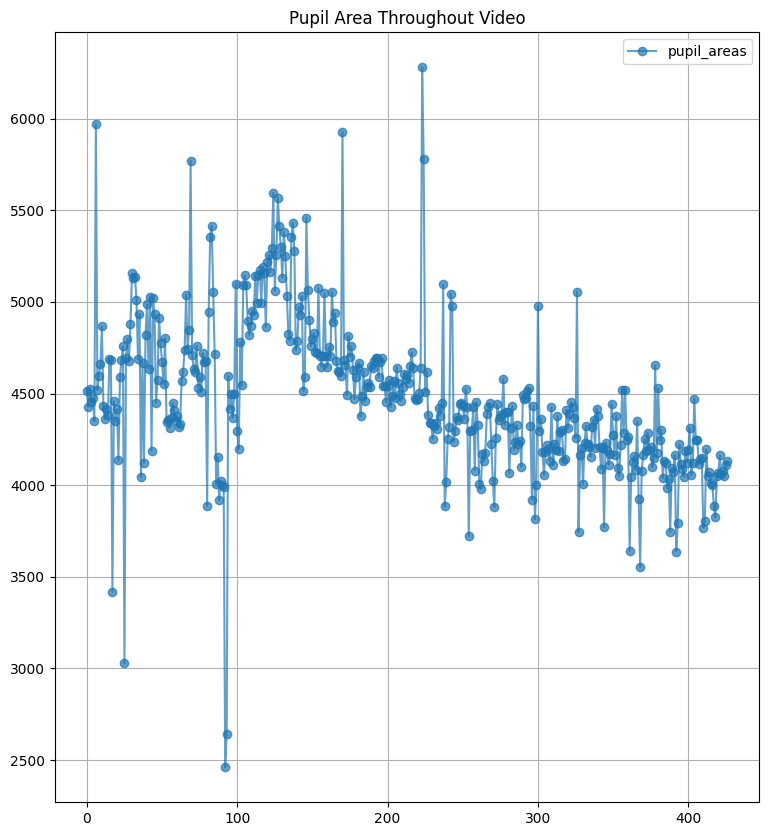

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(pupil_areas, label='pupil_areas', marker='o', alpha=0.7)
plt.grid(True)
plt.legend()
plt.title('Pupil Area Throughout Video')

In [45]:
# the code above does everything for one video (gets a good amount of frames
# and then the pupil areas for each of the frames)
# you can repeat the code for all the other videos too based on what's in your files

In [46]:
from decord import VideoReader
import torch
import torch.nn.functional as F
import decord

device = torch.device('cuda')

decord.bridge.set_bridge('torch')

label = torch.tensor([1], dtype=torch.float32)

def video_process(video):

  vr = VideoReader(video)
  frames = vr.get_batch(range(0, len(vr) - 1, 100))

  frames = F.interpolate(frames.permute(0, 3, 1, 2), size=(256, 256), mode='bilinear', align_corners=False)
  frames = frames.to(device)

  with torch.no_grad():
    output = model(frames.float())['out']

  with torch.no_grad():
   preds = torch.sigmoid(output).cpu().numpy()
   preds = preds > 0.5

  frames_np = frames.cpu().numpy()
  combined = np.concatenate((frames_np, preds[:, np.newaxis]), axis=1)
  combined_tensor = torch.tensor(combined, dtype=torch.float32)
  labeled_tensor = (combined_tensor, label)

  return labeled_tensor